#Подготовка данных
Данная глава посвящена подготовки данных для последующего проведения uplift.
Объединение датафреймов, разбиение на тестовую и трейн выборку, категоризацию, выбор фич.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
!{sys.executable} -m pip install catboost causalml scikit-uplift

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklift.datasets import fetch_x5
from catboost import CatBoostClassifier, CatBoostRegressor
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [4]:
random_state = 47
k = 0.1

In [5]:
def uplift_at_k(uplift_scores, y_true, treatment, k):
    n_top = int(len(uplift_scores) * k)
    indices = np.argsort(-uplift_scores)[:n_top]
    treat_top = treatment.iloc[indices]
    y_top = y_true.iloc[indices]
    return y_top[treat_top == 1].mean() - y_top[treat_top == 0].mean()

In [6]:
df_clients = pd.read_csv('/content/drive/MyDrive/RecSyS/fetch_x5_clients.csv')
df_train = pd.read_csv('/content/drive/MyDrive/RecSyS/fetch_x5_train.csv')
df_clients = df_clients[df_clients['client_id'].isin(df_train['client_id'])]
print(df_clients.shape, df_train.shape)

(200039, 5) (200039, 3)


In [7]:
print(f"Dataset features shape: {df_clients.shape}")
print(f"Dataset train shape: {df_train.shape}")
print(f"Dataset target mean: {df_train.target.mean()}")
print(f"Dataset treatment mean: {df_train.treatment_flg.mean()}")

Dataset features shape: (200039, 5)
Dataset train shape: (200039, 3)
Dataset target mean: 0.6198891216212838
Dataset treatment mean: 0.4998075375301816


In [8]:
df_clients = df_clients.set_index('client_id')
df_train = df_train.set_index('client_id')

In [9]:
df_clients

,first_issue_date,first_redeem_date,age,gender
client_id,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
00010925a5,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
0001f552b0,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F
00020e7b18,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U
...,...,...,...,...
fffe0abb97,2017-11-27 08:56:54,2018-02-11 09:26:08,35,F
fffe0ed719,2017-09-15 08:53:24,2017-12-12 14:50:12,69,U
fffea1204c,2018-01-31 16:59:37,2018-03-12 17:02:27,73,F


In [10]:
# Кодирование категориальных признаков (пол)
cat_features = ['gender']

gender_encoder = LabelEncoder()
df_clients['gender_encoded'] = gender_encoder.fit_transform(df_clients['gender'])

In [11]:
df_clients.columns

Index(['first_issue_date', 'first_redeem_date', 'age', 'gender',
       'gender_encoded'],
      dtype='object')

In [12]:
df_merged = pd.merge(df_clients, df_train, on='client_id', how='inner')

In [14]:
df_merged['first_issue_time'] = (pd.to_datetime(df_merged['first_issue_date'])- pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_merged['first_redeem_time'] = (pd.to_datetime(df_merged['first_redeem_date']) - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_merged['issue_redeem_delay'] = df_merged['first_redeem_time'] - df_merged['first_issue_time']

df_merged.head(2)

,first_issue_date,first_redeem_date,age,gender,gender_encoded,treatment_flg,target,first_issue_time,first_redeem_time,issue_redeem_delay
client_id,,,,,,,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U,2,0,1,1501947648,1.515094e+09,13146559.0
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F,0,1,1,1491832463,1.492951e+09,1118613.0


In [15]:
train, test = train_test_split(df_merged, test_size=0.3, random_state=random_state)

In [16]:
train_features = train[['first_issue_time', 'issue_redeem_delay', 'first_redeem_time', 'age',  'gender_encoded']].copy()
test_features = test[['first_issue_time', 'issue_redeem_delay', 'first_redeem_time', 'age', 'gender_encoded']].copy()

In [17]:
train_t = train_features[train['treatment_flg'] == 1]
train_n_t = train_features[train['treatment_flg'] == 0]

test_t = test_features[test['treatment_flg'] == 1]
test_n_t = test_features[test['treatment_flg'] == 0]

In [18]:
indices_train_t = train_t.index.tolist()
indices_test_t = test_t.index.tolist()

In [19]:
X_train_t = train_features.loc[indices_train_t, :]
y_train_t = df_train.loc[indices_train_t, 'target']
treat_train_t = df_train.loc[indices_train_t, 'treatment_flg']

X_test_t = test_features.loc[indices_test_t, :]
y_test_t = df_train.loc[indices_test_t, 'target']
treat_test_t =  df_train.loc[indices_test_t, 'treatment_flg']

targets = [y_train_t, y_test_t]
treatmnets = [treat_train_t, treat_test_t]
names = ['train:',  'test:']

print('Баланс таргета на разбиениях ЦГ:\n')
i = 0
for target in targets:
    pc = target.mean()
    print(names[i], pc)
    i += 1

print('\nБаланс воздействия на разбиениях ЦГ:\n')
i = 0
for treatmnet in treatmnets:
    pc = treatmnet.mean()
    print(names[i], pc)
    i += 1

Баланс таргета на разбиениях ЦГ:

train: 0.6362519113422982
test: 0.6371150513264898

Баланс воздействия на разбиениях ЦГ:

train: 1.0
test: 1.0


In [20]:
indices_train_n_t = train_n_t.index.tolist()
indices_test_n_t = test_n_t.index.tolist()

In [22]:
X_train_n_t = train_features.loc[indices_train_n_t, :]
y_train_n_t = df_train.loc[indices_train_n_t, 'target']
treat_train_n_t = df_train.loc[indices_train_n_t, 'treatment_flg']

X_test_n_t = test_features.loc[indices_test_n_t, :]
y_test_n_t = df_train.loc[indices_test_n_t, 'target']
treat_test_n_t =  df_train.loc[indices_test_n_t, 'treatment_flg']

targets = [y_train_n_t, y_test_n_t]
treatmnets = [treat_train_n_t, treat_test_n_t]
names = ['train:',  'test:']

print('Баланс таргета на разбиениях КГ:\n')
i = 0
for target in targets:
    pc = target.mean()
    print(names[i], pc)
    i += 1

print('\nБаланс воздействия на разбиениях КГ:\n')
i = 0
for treatmnet in treatmnets:
    pc = treatmnet.mean()
    print(names[i], pc)
    i += 1

Баланс таргета на разбиениях КГ:

train: 0.6039685938615275
test: 0.601672887230072

Баланс воздействия на разбиениях КГ:

train: 0.0
test: 0.0


In [23]:
models_results = {
    'approach': [],
    f'train_uplift@{k*100}%': [],
    f'test_uplift@{k*100}%': []
}

# X-learn
Данная глава посвящена непостредственному проведению uplift X-learn. Обучение нескольких моделей, построение графиков.

In [24]:
def transform_classes(y, treatment):
    return np.where(treatment == 1, y, 1 - y)

## Шаг 1 обучение независимо модели ЦГ И КГ
Обучаются две независимые модели для ЦГ и КГ

### обучение КГ

In [25]:
y_train_transformed_n_t = transform_classes(y_train_n_t, treat_train_n_t)
y_test_transformed_n_t = transform_classes(y_test_n_t, treat_test_n_t)

In [26]:
# обучаем КГ
catboost_model_kg = CatBoostClassifier(
    iterations=1000,
    depth=4,
    learning_rate=0.1,
    random_seed=42,
    verbose=100
)
catboost_model_kg.fit(X_train_n_t, y_train_transformed_n_t)

0:	learn: 0.6860424	total: 70ms	remaining: 1m 9s
100:	learn: 0.6493470	total: 2.98s	remaining: 26.5s
200:	learn: 0.6462896	total: 5.85s	remaining: 23.3s
300:	learn: 0.6440877	total: 7.25s	remaining: 16.8s
400:	learn: 0.6421106	total: 8.66s	remaining: 12.9s
500:	learn: 0.6404825	total: 10.1s	remaining: 10s
600:	learn: 0.6388267	total: 11.5s	remaining: 7.63s
700:	learn: 0.6372882	total: 12.9s	remaining: 5.5s
800:	learn: 0.6359157	total: 14.3s	remaining: 3.55s
900:	learn: 0.6345793	total: 15.8s	remaining: 1.74s
999:	learn: 0.6333690	total: 19.3s	remaining: 0us


In [28]:
y_train_transformed_t = transform_classes(y_train_t, treat_train_t)
y_test_transformed_t = transform_classes(y_test_t, treat_test_t)

### обучение ЦГ

In [29]:
# обучаем ЦГ
catboost_model_сg = CatBoostClassifier(
    iterations=1000,
    depth=4,
    learning_rate=0.1,
    random_seed=42,
    verbose=100
)
catboost_model_сg.fit(X_train_t, y_train_transformed_t)

0:	learn: 0.6820862	total: 16.4ms	remaining: 16.3s
100:	learn: 0.6207864	total: 1.43s	remaining: 12.7s
200:	learn: 0.6177480	total: 2.87s	remaining: 11.4s
300:	learn: 0.6157090	total: 5.59s	remaining: 13s
400:	learn: 0.6137051	total: 8.93s	remaining: 13.3s
500:	learn: 0.6120909	total: 10.8s	remaining: 10.8s
600:	learn: 0.6105394	total: 12.3s	remaining: 8.14s
700:	learn: 0.6090076	total: 13.7s	remaining: 5.84s
800:	learn: 0.6075533	total: 15.1s	remaining: 3.76s
900:	learn: 0.6062469	total: 16.5s	remaining: 1.82s
999:	learn: 0.6050129	total: 18s	remaining: 0us


## Шаг 2 Преобразование таргета
Перемешиваем модели и получаем новые таргеты

In [31]:
y_kg = catboost_model_kg.predict_proba(X_train_t)
y_cg = catboost_model_сg.predict_proba(X_train_n_t)

In [32]:
D_t = y_train_transformed_t - y_kg[:, 1]
D_с = y_cg[:, 0] - y_train_transformed_n_t

## Шаг 3 Таргеты
Обучаем на новых таргетах новые модели

In [33]:
catboost_new_model_t = CatBoostRegressor(
    iterations=1000,
    depth=4,
    learning_rate=0.1,
    random_seed=42,
    verbose=100
)
catboost_new_model_t.fit(X_train_t, D_t)

0:	learn: 0.5114936	total: 10.4ms	remaining: 10.4s
100:	learn: 0.4679013	total: 761ms	remaining: 6.78s
200:	learn: 0.4661133	total: 1.5s	remaining: 5.98s
300:	learn: 0.4649712	total: 2.29s	remaining: 5.33s
400:	learn: 0.4640392	total: 3.07s	remaining: 4.59s
500:	learn: 0.4632686	total: 3.85s	remaining: 3.84s
600:	learn: 0.4625489	total: 4.61s	remaining: 3.06s
700:	learn: 0.4619113	total: 5.42s	remaining: 2.31s
800:	learn: 0.4613194	total: 6.21s	remaining: 1.54s
900:	learn: 0.4607532	total: 6.99s	remaining: 768ms
999:	learn: 0.4601975	total: 7.73s	remaining: 0us


In [34]:
catboost_new_model_n_t = CatBoostRegressor(
    iterations=1000,
    depth=4,
    learning_rate=0.1,
    random_seed=42,
    verbose=100
)
catboost_new_model_n_t.fit(X_train_n_t, D_с)

0:	learn: 0.4803161	total: 9.51ms	remaining: 9.5s
100:	learn: 0.4787922	total: 780ms	remaining: 6.94s
200:	learn: 0.4776986	total: 2.3s	remaining: 9.14s
300:	learn: 0.4767650	total: 3.96s	remaining: 9.2s
400:	learn: 0.4759954	total: 5.71s	remaining: 8.53s
500:	learn: 0.4752449	total: 6.77s	remaining: 6.75s
600:	learn: 0.4745677	total: 7.55s	remaining: 5.01s
700:	learn: 0.4739063	total: 8.32s	remaining: 3.55s
800:	learn: 0.4732940	total: 9.07s	remaining: 2.25s
900:	learn: 0.4727099	total: 9.83s	remaining: 1.08s
999:	learn: 0.4722156	total: 10.6s	remaining: 0us


## Шаг 4 Получение Uplift
Рассчитываем значения uplift и строим графики

In [36]:
g = 0.1

uplift = g * catboost_new_model_n_t.predict(test_features) + (1 - g) * catboost_new_model_t.predict(test_features)

In [40]:
test['uplift'] = uplift

In [41]:
test

,first_issue_date,first_redeem_date,age,gender,gender_encoded,treatment_flg,target,first_issue_time,first_redeem_time,issue_redeem_delay,uplift
client_id,,,,,,,,,,,
9907b709ed,2017-07-25 09:16:06,2017-08-04 18:08:06,70,F,0,1,0,1500974166,1.501870e+09,895920.0,0.523565
f0e06098ef,2017-11-30 21:48:06,2018-05-11 21:40:48,22,M,1,1,0,1512078486,1.526075e+09,13996362.0,0.236549
f6820e7c52,2017-07-10 19:46:23,2018-02-02 16:30:38,53,U,2,1,1,1499715983,1.517589e+09,17873055.0,0.253663
346c68b66c,2017-07-15 21:33:50,2017-11-20 21:32:05,36,F,0,1,1,1500154430,1.511214e+09,11059095.0,0.314487
aa6a47b3fb,2017-04-10 15:55:18,2017-09-24 16:14:42,34,F,0,1,1,1491839718,1.506270e+09,14429964.0,0.203390
...,...,...,...,...,...,...,...,...,...,...,...
0aa6ddb45d,2017-05-24 17:33:27,NaN,23,M,1,1,0,1495647207,NaN,NaN,-0.357501
c231a9a266,2017-08-13 16:41:25,2018-08-31 15:05:08,45,U,2,1,1,1502642485,1.535728e+09,33085423.0,0.090437
0fb517c7e1,2017-07-02 17:53:12,2017-07-31 18:30:41,36,U,2,1,1,1499017992,1.501526e+09,2507849.0,0.319038


In [42]:
def plot_uplift_by_percentile(uplift, y_true, treatment, n_bins=10, title="Uplift by Percentile"):
    """
    Построение графика uplift по процентилям с добавлением средних значений целевой переменной
    для групп лечения и контроля.

    Parameters:
    - uplift: массив оценок uplift.
    - y_true: целевые значения.
    - treatment: индикатор группы лечения.
    - n_bins: количество процентилей.
    - title: заголовок графика.

    Returns:
    - results_df: DataFrame с результатами анализа uplift.
    """
    data = pd.DataFrame({'uplift': uplift, 'y': y_true, 'treatment': treatment})
    data = data.sort_values('uplift', ascending=False).reset_index(drop=True)

    bin_size = len(data) // n_bins
    results = []

    for i in range(n_bins):
        start = i * bin_size
        end = (i + 1) * bin_size if i < n_bins - 1 else len(data)
        bin_data = data.iloc[start:end]

        treat_mean = bin_data.loc[bin_data['treatment'] == 1, 'y'].mean()
        control_mean = bin_data.loc[bin_data['treatment'] == 0, 'y'].mean()
        uplift_value = treat_mean - control_mean
        n_treatment = bin_data.loc[bin_data['treatment'] == 1].shape[0]
        n_control = bin_data.loc[bin_data['treatment'] == 0].shape[0]

        results.append({
            'percentile': i + 1,
            'uplift': uplift_value,
            'treat_mean': treat_mean,
            'control_mean': control_mean,
            'n_treatment': n_treatment,
            'n_control': n_control
        })

    results_df = pd.DataFrame(results)

    plt.plot(results_df['percentile'], results_df['uplift'], marker='o', linestyle='-', label='Uplift')
    plt.plot(results_df['percentile'], results_df['treat_mean'], marker='o', linestyle='--', label='Treatment Mean')
    plt.plot(results_df['percentile'], results_df['control_mean'], marker='o', linestyle='--', label='Control Mean')
    plt.title(title)
    plt.xlabel("Percentile")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(1, n_bins + 1))
    plt.show()

    return results_df


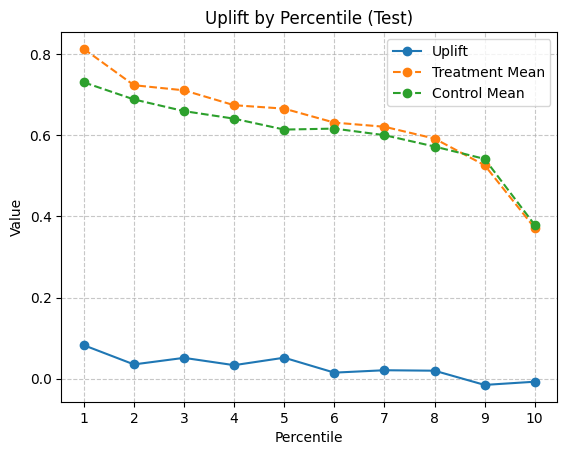

In [59]:
res_X_learn = plot_uplift_by_percentile(test['uplift'].tolist(), test['target'].tolist(), test['treatment_flg'].tolist(), n_bins=10, title="Uplift by Percentile (Test)")

## Сравнение с базовой моделью
Сравниваем с базовой моделью с полученными результатами при X-learn


In [61]:
y_train_transformed = transform_classes(train['target'], train['treatment_flg'])
y_test_transformed = transform_classes(test['target'], test['treatment_flg'])

catboost_model = CatBoostClassifier(
    iterations=1000,
    depth=4,
    learning_rate=0.1,
    random_seed=42,
    verbose=100
)
catboost_model.fit(train_features, y_train_transformed)

uplift_train_CB = catboost_model.predict_proba(train_features)[:, 1] - catboost_model.predict_proba(train_features)[:, 0]
uplift_test_CB = catboost_model.predict_proba(test_features)[:, 1] - catboost_model.predict_proba(test_features)[:, 0]

0:	learn: 0.6921552	total: 32.1ms	remaining: 32.1s
100:	learn: 0.6879165	total: 2.44s	remaining: 21.7s
200:	learn: 0.6868034	total: 4.85s	remaining: 19.3s
300:	learn: 0.6858361	total: 7.3s	remaining: 17s
400:	learn: 0.6849146	total: 9.77s	remaining: 14.6s
500:	learn: 0.6840929	total: 15.1s	remaining: 15s
600:	learn: 0.6833093	total: 17.6s	remaining: 11.7s
700:	learn: 0.6826274	total: 20s	remaining: 8.55s
800:	learn: 0.6819872	total: 22.5s	remaining: 5.58s
900:	learn: 0.6813593	total: 24.9s	remaining: 2.74s
999:	learn: 0.6806942	total: 30.1s	remaining: 0us


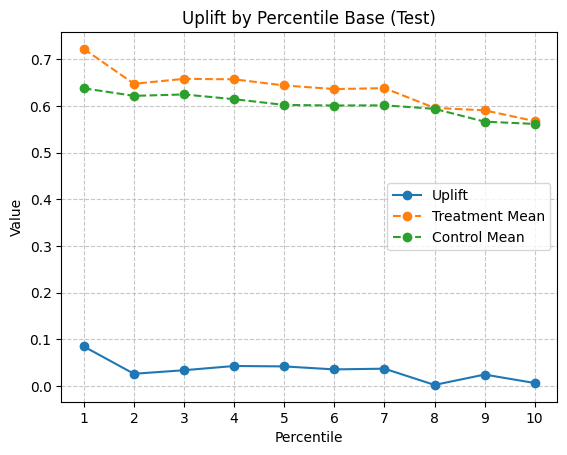

In [62]:
res_base = plot_uplift_by_percentile(uplift_test_CB, test['target'].tolist(), test['treatment_flg'].tolist(), n_bins=10, title="Uplift by Percentile Base (Test)")

In [63]:
res_X_learn

,percentile,uplift,treat_mean,control_mean,n_treatment,n_control
0,1,0.082450,0.813305,0.730856,3337,2664
1,2,0.035080,0.723788,0.688708,3052,2949
2,3,0.051271,0.711179,0.659908,2943,3058
3,4,0.033215,0.674457,0.641242,3038,2963
4,5,0.051659,0.665997,0.614338,2988,3013
5,6,0.014800,0.631579,0.616779,3021,2980
6,7,0.020722,0.621327,0.600606,3029,2972
7,8,0.019582,0.592123,0.572541,2920,3081
8,9,-0.015499,0.526466,0.541966,2796,3205
9,10,-0.007595,0.371528,0.379123,2880,3123


In [64]:
res_base

,percentile,uplift,treat_mean,control_mean,n_treatment,n_control
0,1,0.084420,0.722123,0.637703,3354,2647
1,2,0.025878,0.647444,0.621567,3052,2949
2,3,0.033518,0.658029,0.624511,2933,3068
3,4,0.042580,0.656979,0.614398,2959,3042
4,5,0.041687,0.643813,0.602126,2990,3011
5,6,0.035264,0.636118,0.600854,2957,3044
6,7,0.036845,0.638051,0.601206,3017,2984
7,8,0.002012,0.595752,0.593740,2966,3035
8,9,0.024213,0.590451,0.566237,2974,3027
9,10,0.006065,0.567452,0.561387,2802,3201


In [70]:
diff_uplift = res_X_learn['uplift'] - res_base['uplift']

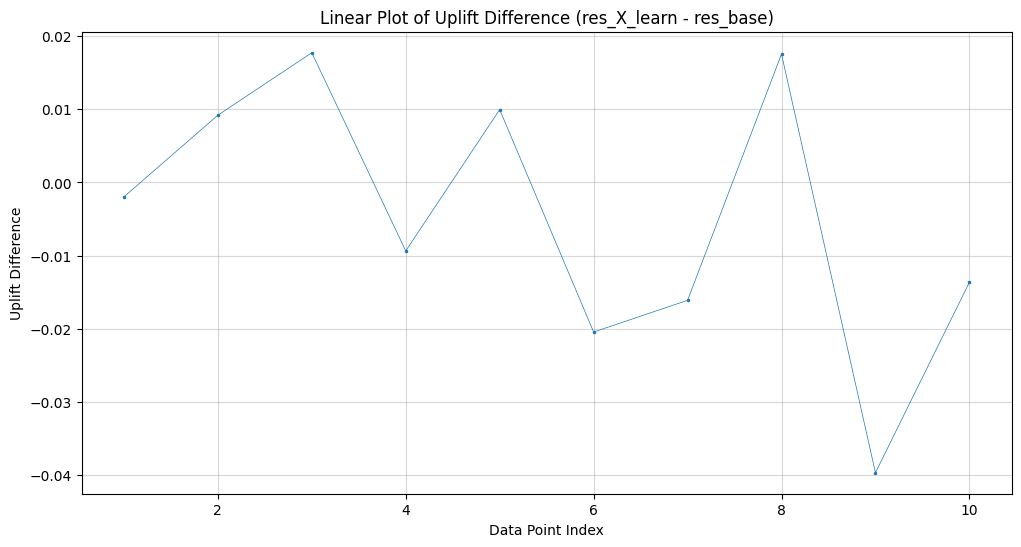

In [74]:
plt.figure(figsize=(12, 6))
plt.plot(diff_uplift.index + 1, diff_uplift.values, marker='.', linestyle='-', linewidth=0.5, markersize=3)
plt.title('Linear Plot of Uplift Difference (res_X_learn - res_base)')
plt.xlabel('Data Point Index')
plt.ylabel('Uplift Difference')
plt.grid(True, alpha=0.5)
plt.show()